In [10]:
#@title B-SOiD GOOGLE COLAB v1.2.1 
# Created by Yttri Lab at Carnegie Mellon University.
# Program developer: Alexander Hsu.
# Program collaborator: Vishal Patel.
# Date last modified: 041820
# Contact: ahsu2@andrew.cmu.edu

# Import necessary python packages

import glob
import logging
import math
import os
import re
import sys
import time

import joblib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.axes._axes import _log as matplotlib_axes_logger
import numpy as np
import pandas as pd
import seaborn as sn

!pip install bhtsne

from bhtsne import tsne
from sklearn import mixture, svm
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

matplotlib_axes_logger.setLevel('ERROR')

In [0]:
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level='INFO',
    datefmt='%Y-%m-%d %H:%M:%S',
    stream=sys.stdout)

# Load your pose estimate data (.csv) generated from either [DeepLabCut](https://github.com/AlexEMG/DeepLabCut).

In [12]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Defining *parameters* based on your data.


In [0]:
# Load your data
# Step 1: change BASE_PATH to "/content/drive/My Drive/DeepLabCut/"
# Step 2: change TRAIN_FOLDERS to ["experiment1","experiment2","more"]
BASE_PATH = "/content/drive/My Drive/Colab Notebooks/"
TRAIN_FOLDERS = ["041919"]
PREDICT_FOLDERS = ["041919"]  # Folder paths containing new dataset to predict using built classifier.


In [0]:
# Minimum is the 6 I listed below. Please order them based on your csv orders.
# Can have more, but not less.
BODYPARTS = {
    'Snout/Head': 0,
    'Neck': None,
    'Forepaw/Shoulder1': 1,
    'Forepaw/Shoulder2': 2,
    'Bodycenter': None,
    'Hindpaw/Hip1': 3,
    'Hindpaw/Hip2': 4,
    'Tailbase': 5,
    'Tailroot': None
}

# note that you can use a different number for new data as long as the video is same scale/view
FPS = 60  # Frame-rate of your video,

# IF YOU'D LIKE TO SKIP PLOTTING/CREATION OF VIDEOS, change below plot settings to False
PLOT_TRAINING = True
GEN_VIDEOS = False # set this to true only if you have sufficient drive space

# Output directory to where you want the analysis to be stored
OUTPUT_PATH = '/content/drive/My Drive/Colab Notebooks/'
MODEL_NAME = 'c57bl6_n2_120min' # Your machine learning model name

# IF GEN_VIDEOS = True
# Pick the video
VID_NAME = '/content/drive/My Drive/Colab Notebooks/041919/2019-04-19_09-34-36cut0_30min.mp4'
# What number would be video be in terms of prediction order? (0=file 1/folder1, 1=file2/folder 1, etc.)
ID = 0
# Create a folder to store extracted images and videos make sure these folders exist.
# This program will predict labels and print them on these images
FRAME_DIR = '/content/drive/My Drive/Colab Notebooks/041919/0_30min_10fpsPNGs'
# In addition, this will also create an entire sample group videos for ease of understanding
SHORTVID_DIR = '/content/drive/My Drive/Colab Notebooks/examples'

###########################################################################################
######## UNLESS YOU WANT TO TUNE B-SOID PARAMETERS, LEAVE THE FOLLOWING TO DEFAULT ########
###########################################################################################
COMP = 1  # COMP = 1: Train one classifier for all CSV files; COMP = 0: Classifier/CSV file.

# Expectation Maximization: Mixture models parameters
EMGMM_PARAMS = {
    'n_components': 30,
    'covariance_type': 'full', # t-SNE has no structure
    'tol': 0.001,
    'reg_covar': 1e-06,
    'max_iter': 100,
    'n_init': 10, # 10 iterations to escape poor initialization
    'init_params': 'random', # random initialization
    'random_state': 23,
    'verbose': 1 # set this to 0 if you don't want to show progress for em-gmm.
}

# SVM parameters
SVM_PARAMS = {
    'gamma': 0.5,  # Kernel coefficient
    'C': 10,  # Regularization parameter
    'probability': True,
    'random_state': 23,
    'verbose': 0 # set this to 1 if you want to show optimization progress
}

HLDOUT = 0.2  # Test partition ratio to validate clustering separation.
CV_IT = 10  # Number of iterations for cross-validation to show it's not over-fitting.

In [0]:
#@title Define all the *functions* necessary.
def boxcar_center(a, n):

  a1 = pd.Series(a)
  moving_avg = np.array(a1.rolling(window = n,min_periods=1,center = True).mean())
  
  return moving_avg 


def convert_int(s):
    """ Converts digit string to integer
    """
    if s.isdigit():
        return int(s)
    else:
        return s


def alphanum_key(s):
    """ Turn a string into a list of string and number chunks.
        "z23a" -> ["z", 23, "a"]
    """
    return [convert_int(c) for c in re.split('([0-9]+)', s)]


def sort_nicely(l):
    """ Sort the given list in the way that humans expect.
    """
    l.sort(key=alphanum_key)


def get_filenames(folder):
    """
    Gets a list of filenames within a folder
    :param folder: str, folder path
    :return: list, filenames
    """
    filenames = glob.glob(BASE_PATH + folder + '/*.csv')
    sort_nicely(filenames)
    return filenames


def adp_filt(currdf: object):
    """
    :param currdf: object, csv data frame
    :return currdf_filt: 2D array, filtered data
    :return perc_rect: 1D array, percent filtered per BODYPART
    """
    lIndex = []
    xIndex = []
    yIndex = []
    currdf = np.array(currdf[1:])
    for header in range(len(currdf[0])):
        if currdf[0][header] == "likelihood":
            lIndex.append(header)
        elif currdf[0][header] == "x":
            xIndex.append(header)
        elif currdf[0][header] == "y":
            yIndex.append(header)
    logging.info('Extracting likelihood value...')
    currdf = np.array(currdf)
    curr_df1 = currdf[:, 1:]
    datax = curr_df1[:, np.array(xIndex) - 1]
    datay = curr_df1[:, np.array(yIndex) - 1]
    data_lh = curr_df1[:, np.array(lIndex) - 1]
    currdf_filt = np.zeros((datax.shape[0] - 1, (datax.shape[1]) * 2))
    perc_rect = []
    logging.info('Computing data threshold to forward fill any sub-threshold (x,y)...')
    for i in range(data_lh.shape[1]):
        perc_rect.append(0)
    for x in tqdm(range(data_lh.shape[1])):
        a, b = np.histogram(data_lh[1:, x].astype(np.float))
        rise_a = np.where(np.diff(a) >= 0)
        if rise_a[0][0] > 1:
            llh = (b[rise_a[0][0]+1])
        else:
            llh = (b[rise_a[0][1]+1])
        data_lh_float = data_lh[1:, x].astype(np.float)
        perc_rect[x] = np.sum(data_lh_float < llh) / data_lh.shape[0]
        for i in range(1, data_lh.shape[0] - 1):
            if data_lh_float[i] < llh:
                currdf_filt[i, (2 * x):(2 * x + 2)] = currdf_filt[i - 1, (2 * x):(2 * x + 2)]
            else:
                currdf_filt[i, (2 * x):(2 * x + 2)] = np.hstack([datax[i, x], datay[i, x]])
    currdf_filt = np.array(currdf_filt[1:])
    currdf_filt = currdf_filt.astype(np.float)
    return currdf_filt, perc_rect


def import_folders(folders: list):
    """
    Import multiple folders containing .csv files and process them
    :param folders: list, data folders
    :return filenames: list, data filenames
    :return data: list, filtered csv data
    :return perc_rect_li: list, percent filtered
    """
    filenames = []
    rawdata_li = []
    data_li = []
    perc_rect_li = []
    for i, fd in enumerate(folders):  # Loop through folders
        f = get_filenames(fd)
        for j, filename in enumerate(f):
            logging.info('Importing CSV file {} from folder {}'.format(j + 1, i + 1))
            curr_df = pd.read_csv(filename, low_memory=False)
            curr_df_filt, perc_rect = adp_filt(curr_df)
            logging.info('Done preprocessing (x,y) from file {}, folder {}.'.format(j + 1, i + 1))
            rawdata_li.append(curr_df)
            perc_rect_li.append(perc_rect)
            data_li.append(curr_df_filt)
        filenames.append(f)
        logging.info('Processed {} CSV files from folder: {}'.format(len(f), fd))
    data = np.array(data_li)
    logging.info('Processed a total of {} CSV files, and compiled into a {} data list.'.format(len(data_li),
                                                                                               data.shape))
    return filenames, data, perc_rect_li


def likelihoodprocessing(folders):
    """
    :param folders: list, data folders
    :return filenames: list, data filenames
    :return data: list, filtered data list
    :retrun perc_rect: 1D array, percent filtered per BODYPART
    """
    filenames, data, perc_rect = import_folders(folders)
    return filenames, data, perc_rect


def plot_classes(data, assignments):
    """ Plot trained_tsne for EM-GMM assignments
    :param data: 2D array, trained_tsne
    :param assignments: 1D array, EM-GMM assignments
    """
    uk = list(np.unique(assignments))
    R = np.linspace(0, 1, len(uk))
    cmap = plt.cm.get_cmap("Spectral")(R)
    tsne_x, tsne_y, tsne_z = data[:, 0], data[:, 1], data[:, 2]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for g in np.unique(assignments):
        idx = np.where(np.array(assignments) == g)
        ax.scatter(tsne_x[idx], tsne_y[idx], tsne_z[idx], c=cmap[g],
                   label=g, s=0.5, marker='o', alpha=0.8)
    ax.set_xlabel('Dim. 1')
    ax.set_ylabel('Dim. 2')
    ax.set_zlabel('Dim. 3')
    ax.view_init(70, 135)
    plt.title('Assignments by GMM')
    plt.legend(ncol=3)
    plt.show()
    timestr = time.strftime("_%Y%m%d_%H%M")
    my_file = 'train_assignments_'
    fig.savefig(os.path.join(OUTPUT_PATH, str.join('', (my_file, timestr, '.svg'))))


def plot_accuracy(scores):
    """
    :param scores: 1D array, cross-validated accuracies for SVM classifier.
    """
    fig = plt.figure(facecolor='w', edgecolor='k')
    fig.suptitle("Performance on {} % data".format(HLDOUT * 100))
    ax = fig.add_subplot(111)
    ax.boxplot(scores, notch=None)
    x = np.random.normal(1, 0.04, size=len(scores))
    plt.scatter(x, scores, s=40, c='r', alpha=0.5)
    ax.set_xlabel('SVM RBF classifier')
    ax.set_ylabel('Accuracy')
    plt.show()
    timestr = time.strftime("_%Y%m%d_%H%M")
    my_file = 'clf_scores_'
    fig.savefig(os.path.join(OUTPUT_PATH, str.join('', (my_file, timestr, '.svg'))))


def plot_tmat(tm: object, fps):
    """
    :param tm: object, transition matrix data frame
    :param fps: scalar, camera frame-rate
    """
    timestr = time.strftime("_%Y%m%d_%H%M")
    fig = plt.figure()
    fig.suptitle("Transition matrix of {} behaviors".format(tm.shape[0]))
    sn.heatmap(tm, annot=True)
    plt.xlabel("Next frame behavior")
    plt.ylabel("Current frame behavior")
    plt.show()
    my_file = 'transition_matrix_'
    fig.savefig(os.path.join(OUTPUT_PATH, str.join('', (my_file, str(fps), timestr, '.svg'))))
    return


def plot_feats(feats: list, labels: list):
    """
    :param feats: list, features for multiple sessions
    :param labels: list, labels for multiple sessions
    """
    result = isinstance(labels, list)
    timestr = time.strftime("_%Y%m%d_%H%M")
    if result:
        for k in range(0, len(feats)):
            labels_k = np.array(labels[k])
            feats_k = np.array(feats[k])
            R = np.linspace(0, 1, len(np.unique(labels_k)))
            color = plt.cm.get_cmap("Spectral")(R)
            feat_ls = ("Relative snout to forepaws placement", "Relative snout to hind paws placement",
                       "Inter-forepaw distance", "Body length", "Body angle",
                       "Snout displacement", "Tail-base displacement")
            for j in range(0, feats_k.shape[0]):
                fig = plt.figure(facecolor='w', edgecolor='k')
                for i in range(0, len(np.unique(labels_k))):
                    plt.subplot(len(np.unique(labels_k)), 1, i + 1)
                    if j == 2 or j == 3 or j == 5 or j == 6:
                        plt.hist(feats_k[j, labels_k == i],
                                 bins=np.linspace(0, np.mean(feats_k[j, :]) + 3 * np.std(feats_k[j, :]), num=50),
                                 range=(0, np.mean(feats_k[j, :]) + 3 * np.std(feats_k[j, :])),
                                 color=color[i], density=True)
                        fig.suptitle("{} pixels".format(feat_ls[j]))
                        plt.xlim(0, np.mean(feats_k[j, :]) + 3 * np.std(feats_k[j, :]))
                        if i < len(np.unique(labels_k)) - 1:
                            plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
                    else:
                        plt.hist(feats_k[j, labels_k == i],
                                 bins=np.linspace(np.mean(feats_k[j, :]) - 3 * np.std(feats_k[j, :]),
                                                  np.mean(feats_k[j, :]) + 3 * np.std(feats_k[j, :]), num=50),
                                 range=(np.mean(feats_k[j, :]) - 3 * np.std(feats_k[j, :]),
                                        np.mean(feats_k[j, :]) + 3 * np.std(feats_k[j, :])),
                                 color=color[i], density=True)
                        plt.xlim(np.mean(feats_k[j, :]) - 3 * np.std(feats_k[j, :]),
                                 np.mean(feats_k[j, :]) + 3 * np.std(feats_k[j, :]))
                        fig.suptitle("{} pixels".format(feat_ls[j]))
                        if i < len(np.unique(labels_k)) - 1:
                            plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
                my_file = 'sess{}_feat{}_hist_'.format(k + 1, j + 1)
                fig.savefig(os.path.join(OUTPUT_PATH, str.join('', (my_file, timestr, '.svg'))))
            plt.show()
    else:
        R = np.linspace(0, 1, len(np.unique(labels)))
        color = plt.cm.get_cmap("Spectral")(R)
        feat_ls = ("Relative snout to forepaws placement", "Relative snout to hind paws placement",
                   "Inter-forepaw distance", "Body length", "Body angle",
                   "Snout displacement", "Tail-base displacement")
        for j in range(0, feats.shape[0]):
            fig = plt.figure(facecolor='w', edgecolor='k')
            for i in range(0, len(np.unique(labels))):
                plt.subplot(len(np.unique(labels)), 1, i + 1)
                if j == 2 or j == 3 or j == 5 or j == 6:
                    plt.hist(feats[j, labels == i],
                             bins=np.linspace(0, np.mean(feats[j, :]) + 3 * np.std(feats[j, :]), num=50),
                             range=(0, np.mean(feats[j, :]) + 3 * np.std(feats[j, :])),
                             color=color[i], density=True)
                    fig.suptitle("{} pixels".format(feat_ls[j]))
                    plt.xlim(0, np.mean(feats[j, :]) + 3 * np.std(feats[j, :]))
                    if i < len(np.unique(labels)) - 1:
                        plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
                else:
                    plt.hist(feats[j, labels == i],
                             bins=np.linspace(np.mean(feats[j, :]) - 3 * np.std(feats[j, :]),
                                              np.mean(feats[j, :]) + 3 * np.std(feats[j, :]), num=50),
                             range=(np.mean(feats[j, :]) - 3 * np.std(feats[j, :]),
                                    np.mean(feats[j, :]) + 3 * np.std(feats[j, :])),
                             color=color[i], density=True)
                    plt.xlim(np.mean(feats[j, :]) - 3 * np.std(feats[j, :]),
                             np.mean(feats[j, :]) + 3 * np.std(feats[j, :]))
                    fig.suptitle("{} pixels".format(feat_ls[j]))
                    if i < len(np.unique(labels)) - 1:
                        plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
            my_file = 'feat{}_hist_'.format(j + 1)
            fig.savefig(os.path.join(OUTPUT_PATH, str.join('', (my_file, timestr, '.svg'))))
        plt.show()


def transition_matrix(labels):
    """
    :param labels: 1D array, predicted labels
    :return df_tm: object, transition matrix data frame
    """
    n = 1 + max(labels)
    tm = [[0] * n for _ in range(n)]
    for (i, j) in zip(labels, labels[1:]):
        tm[i][j] += 1
    for row in tm:
        s = sum(row)
        if s > 0:
            row[:] = [f / s for f in row]
    df_tm = pd.DataFrame(tm)
    return df_tm


def rle(inarray):
    """ run length encoding. Partial credit to R rle function.
        Multi datatype arrays catered for including non Numpy
        returns: tuple (runlengths, startpositions, values) """
    ia = np.asarray(inarray)  # force numpy
    n = len(ia)
    if n == 0:
        return (None, None, None)
    else:
        y = np.array(ia[1:] != ia[:-1])  # pairwise unequal (string safe)
        i = np.append(np.where(y), n - 1)  # must include last element posi
        z = np.diff(np.append(-1, i))  # run lengths
        p = np.cumsum(np.append(0, z))[:-1]  # positions
        return z, p, ia[i]


def behv_time(labels):
    """
    :param labels: 1D array, predicted labels
    :return beh_t: 1D array, percent time for each label
    """
    beh_t = []
    for i in range(0, len(np.unique(labels))):
        t = np.sum(labels == i) / labels.shape[0]
        beh_t.append(t)
    return beh_t


def behv_dur(labels):
    """
    :param labels: 1D array, predicted labels
    :return runlen_df: object, behavioral duration run lengths data frame
    :return dur_stats: object, behavioral duration statistics data frame
    """
    lengths, pos, grp = rle(labels)
    df_lengths = pd.DataFrame(lengths, columns={'Run lengths'})
    df_grp = pd.DataFrame(grp, columns={'B-SOiD labels'})
    df_pos = pd.DataFrame(pos, columns={'Start time (frames)'})
    runlengths = [df_grp, df_pos, df_lengths]
    runlen_df = pd.concat(runlengths, axis=1)
    beh_t = behv_time(labels)
    dur_means = []
    dur_quant0 = []
    dur_quant1 = []
    dur_quant2 = []
    dur_quant3 = []
    dur_quant4 = []
    for i in range(0, len(np.unique(grp))):
        try:
            dur_means.append(np.mean(lengths[np.where(grp == i)]))
            dur_quant0.append(np.quantile(lengths[np.where(grp == i)], 0.1))
            dur_quant1.append(np.quantile(lengths[np.where(grp == i)], 0.25))
            dur_quant2.append(np.quantile(lengths[np.where(grp == i)], 0.5))
            dur_quant3.append(np.quantile(lengths[np.where(grp == i)], 0.75))
            dur_quant4.append(np.quantile(lengths[np.where(grp == i)], 0.9))
        except:
            # dur_means.append(0)
            dur_quant0.append(0)
            dur_quant1.append(0)
            dur_quant2.append(0)
            dur_quant3.append(0)
            dur_quant4.append(0)
    alldata = np.concatenate([np.array(beh_t).reshape(len(np.array(beh_t)), 1),
                              np.array(dur_means).reshape(len(np.array(dur_means)), 1),
                              np.array(dur_quant0).reshape(len(np.array(dur_quant0)), 1),
                              np.array(dur_quant1).reshape(len(np.array(dur_quant1)), 1),
                              np.array(dur_quant2).reshape(len(np.array(dur_quant2)), 1),
                              np.array(dur_quant3).reshape(len(np.array(dur_quant3)), 1),
                              np.array(dur_quant4).reshape(len(np.array(dur_quant4)), 1)], axis=1)
    micolumns = pd.MultiIndex.from_tuples([('Stats', 'Percent of time'),
                                           ('', 'Mean duration (frames)'), ('', '10th %tile (frames)'),
                                           ('', '25th %tile (frames)'), ('', '50th %tile (frames)'),
                                           ('', '75th %tile (frames)'), ('', '90th %tile (frames)')],
                                          names=['', 'B-SOiD labels'])
    dur_stats = pd.DataFrame(alldata, columns=micolumns)
    return runlen_df, dur_stats


def bsoid_stats(labels, output_path=OUTPUT_PATH):
    """
    :param labels: 1D array: predicted labels
    :param output_path: string, output directory
    :return dur_stats: object, behavioral duration statistics data frame
    :return tm: object, transition matrix data frame
    """
    runlen_df, dur_stats = behv_dur(labels)
    tm = transition_matrix(labels)
    return runlen_df, dur_stats, tm


def get_vidnames(folder):
    """
    Gets a list of filenames within a folder
    :param folder: str, folder path
    :return: list, video filenames
    """
    vidnames = glob.glob(BASE_PATH + folder + '/*.mp4')
    sort_nicely(vidnames)
    return vidnames


def vid2frame(vidname, labels, fps, output_path=FRAME_DIR):
    """
    Extracts frames every 100ms to match the labels for visualizations
    :param vidname: string, path to video
    :param labels: 1D array, labels from training
    :param fps: scalar, frame-rate of original camera
    :param output_path: string, path to output
    """
    vidobj = cv2.VideoCapture(vidname)
    pbar = tqdm(total=int(vidobj.get(cv2.CAP_PROP_FRAME_COUNT)))
    width = vidobj.get(3)
    height = vidobj.get(4)
    labels = np.hstack((labels[0],labels)) # fill the first frame
    count = 0
    count1 = 0
    font_scale = 1
    font = cv2.FONT_HERSHEY_COMPLEX
    rectangle_bgr = (0, 0, 0)
    while vidobj.isOpened():
        ret, frame = vidobj.read()
        if ret:
            text = 'Group' + str(labels[count1])
            (text_width, text_height) = cv2.getTextSize(text, font, fontScale=font_scale, thickness=1)[0]
            text_offset_x = 50
            text_offset_y = 50
            box_coords = ((text_offset_x - 12, text_offset_y + 12),
                          (text_offset_x + text_width + 12, text_offset_y - text_height - 8))
            cv2.rectangle(frame, box_coords[0], box_coords[1], rectangle_bgr, cv2.FILLED)
            cv2.putText(frame, text, (text_offset_x, text_offset_y), font,
                        fontScale=font_scale, color=(255, 255, 255), thickness=1)
            cv2.imwrite(os.path.join(output_path, 'frame{:d}.png'.format(count1)), frame)
            count += round(fps / 10)  # i.e. at 60fps, this skips every 5
            count1 += 1
            vidobj.set(1, count)
            pbar.update(round(fps / 10))
        else:
            vidobj.release()
            break
    pbar.close()
    return


def import_vidfolders(folders: list, output_path: list):
    """
    Import multiple folders containing .mp4 files and extract frames from them
    :param folders: list of folder paths
    :param output_path: list, directory to where you want to store extracted vid images in LOCAL_CONFIG
    """
    vidnames = []
    for i, fd in enumerate(folders):  # Loop through folders
        v = get_vidnames(fd)
        for j, vidname in enumerate(v):
            logging.info('Extracting frames from {} and appending labels to these images...'.format(vidname))
            vid2frame(vidname, output_path)
            logging.info('Done extracting images and writing labels, from MP4 file {}'.format(j + 1))
        vidnames.append(v)
        logging.info('Processed {} MP4 files from folder: {}'.format(len(v), fd))
    return


def repeatingNumbers(labels):
    """
    :param labels: 1D array, predicted labels
    :return n_list: 1D array, the label number
    :return idx: 1D array, label start index
    :return lengths: 1D array, how long each bout lasted for
    """
    i = 0
    n_list = []
    idx = []
    lengths = []
    while i < len(labels) - 1:
        n = labels[i]
        n_list.append(n)
        startIndex = i
        idx.append(i)
        while i < len(labels) - 1 and labels[i] == labels[i + 1]:
            i = i + 1
        endIndex = i
        length = endIndex - startIndex
        lengths.append(length)
        i = i + 1
    return n_list, idx, lengths


def create_labeled_vid(labels, crit=3, counts=5, frame_dir=FRAME_DIR, output_path=SHORTVID_DIR):
    """
    :param labels: 1D array, labels from training or testing
    :param crit: scalar, minimum duration for random selection of behaviors, default 300ms
    :param counts: scalar, number of randomly generated examples, default 5
    :param frame_dir: string, directory to where you extracted vid images in LOCAL_CONFIG
    :param output_path: string, directory to where you want to store short video examples in LOCAL_CONFIG
    """
    images = [img for img in os.listdir(frame_dir) if img.endswith(".png")]
    sort_nicely(images)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    frame = cv2.imread(os.path.join(frame_dir, images[0]))
    height, width, layers = frame.shape
    rnges = []
    n, idx, lengths = repeatingNumbers(labels)
    idx2 = []
    for i, j in enumerate(lengths):
        if j >= crit:
            rnges.append(range(idx[i], idx[i] + j))
            idx2.append(i)
    for i in tqdm(range(0, len(np.unique(labels)))):
        a = []
        for j in range(0, len(rnges)):
            if n[idx2[j]] == i:
                a.append(rnges[j])
        try:
            rand_rnges = random.sample(a, counts)
            for k in range(0, len(rand_rnges)):
                video_name = 'group_{}_example_{}.mp4'.format(i, k)
                grpimages = []
                for l in rand_rnges[k]:
                    grpimages.append(images[l])
                video = cv2.VideoWriter(os.path.join(output_path, video_name), fourcc, 5, (width, height))
                for image in grpimages:
                    video.write(cv2.imread(os.path.join(frame_dir, image)))
                cv2.destroyAllWindows()
                video.release()
        except:
            pass
    return


def videoprocessing(vidname, labels, fps, output_path):
    vid2frame(vidname, labels, fps, output_path)
    create_labeled_vid(labels, crit=3, counts=5, frame_dir=output_path, output_path=SHORTVID_DIR)
    return


def bsoid_tsne(data: list, bodyparts=BODYPARTS, fps=FPS, comp=COMP):
    """
    Trains t-SNE (unsupervised) given a set of features based on (x,y) positions
    :param data: list of 3D array
    :param bodyparts: dict, body parts with their orders in LOCAL_CONFIG
    :param fps: scalar, argument specifying camera frame-rate in LOCAL_CONFIG
    :param comp: boolean (0 or 1), argument to compile data or not in LOCAL_CONFIG
    :return f_10fps: 2D array, features
    :retrun f_10fps_sc: 2D array, standardized features
    :return trained_tsne: 2D array, trained t-SNE space
    """
    win_len = np.int(np.round(0.05 / (1 / fps)) * 2 - 1)
    feats = []
    for m in range(len(data)):
        logging.info('Extracting features from CSV file {}...'.format(m + 1))
        dataRange = len(data[m])
        fpd = data[m][:, 2 * bodyparts.get('Forepaw/Shoulder1'):2 * bodyparts.get('Forepaw/Shoulder1') + 2] - \
              data[m][:, 2 * bodyparts.get('Forepaw/Shoulder2'):2 * bodyparts.get('Forepaw/Shoulder2') + 2]
        cfp = np.vstack(((data[m][:, 2 * bodyparts.get('Forepaw/Shoulder1')] +
                          data[m][:, 2 * bodyparts.get('Forepaw/Shoulder2')]) / 2,
                         (data[m][:, 2 * bodyparts.get('Forepaw/Shoulder1') + 1] +
                          data[m][:, 2 * bodyparts.get('Forepaw/Shoulder1') + 1]) / 2)).T
        cfp_pt = np.vstack(([cfp[:, 0] - data[m][:, 2 * bodyparts.get('Tailbase')],
                             cfp[:, 1] - data[m][:, 2 * bodyparts.get('Tailbase') + 1]])).T
        chp = np.vstack((((data[m][:, 2 * bodyparts.get('Hindpaw/Hip1')] +
                           data[m][:, 2 * bodyparts.get('Hindpaw/Hip2')]) / 2),
                         ((data[m][:, 2 * bodyparts.get('Hindpaw/Hip1') + 1] +
                           data[m][:, 2 * bodyparts.get('Hindpaw/Hip2') + 1]) / 2))).T
        chp_pt = np.vstack(([chp[:, 0] - data[m][:, 2 * bodyparts.get('Tailbase')],
                             chp[:, 1] - data[m][:, 2 * bodyparts.get('Tailbase') + 1]])).T
        sn_pt = np.vstack(([data[m][:, 2 * bodyparts.get('Snout/Head')] - data[m][:, 2 * bodyparts.get('Tailbase')],
                            data[m][:, 2 * bodyparts.get('Snout/Head') + 1] - data[m][:,
                                                                              2 * bodyparts.get('Tailbase') + 1]])).T
        fpd_norm = np.zeros(dataRange)
        cfp_pt_norm = np.zeros(dataRange)
        chp_pt_norm = np.zeros(dataRange)
        sn_pt_norm = np.zeros(dataRange)
        for i in range(1, dataRange):
            fpd_norm[i] = np.array(np.linalg.norm(fpd[i, :]))
            cfp_pt_norm[i] = np.linalg.norm(cfp_pt[i, :])
            chp_pt_norm[i] = np.linalg.norm(chp_pt[i, :])
            sn_pt_norm[i] = np.linalg.norm(sn_pt[i, :])
        fpd_norm_smth = boxcar_center(fpd_norm, win_len)
        sn_cfp_norm_smth = boxcar_center(sn_pt_norm - cfp_pt_norm, win_len)
        sn_chp_norm_smth = boxcar_center(sn_pt_norm - chp_pt_norm, win_len)
        sn_pt_norm_smth = boxcar_center(sn_pt_norm, win_len)
        sn_pt_ang = np.zeros(dataRange - 1)
        sn_disp = np.zeros(dataRange - 1)
        pt_disp = np.zeros(dataRange - 1)
        for k in range(0, dataRange - 1):
            b_3d = np.hstack([sn_pt[k + 1, :], 0])
            a_3d = np.hstack([sn_pt[k, :], 0])
            c = np.cross(b_3d, a_3d)
            sn_pt_ang[k] = np.dot(np.dot(np.sign(c[2]), 180) / np.pi,
                                  math.atan2(np.linalg.norm(c), np.dot(sn_pt[k, :], sn_pt[k + 1, :])))
            sn_disp[k] = np.linalg.norm(
                data[m][k + 1, 2 * bodyparts.get('Snout/Head'):2 * bodyparts.get('Snout/Head') + 1] -
                data[m][k, 2 * bodyparts.get('Snout/Head'):2 * bodyparts.get('Snout/Head') + 1])
            pt_disp[k] = np.linalg.norm(
                data[m][k + 1, 2 * bodyparts.get('Tailbase'):2 * bodyparts.get('Tailbase') + 1] -
                data[m][k, 2 * bodyparts.get('Tailbase'):2 * bodyparts.get('Tailbase') + 1])
        sn_pt_ang_smth = boxcar_center(sn_pt_ang, win_len)
        sn_disp_smth = boxcar_center(sn_disp, win_len)
        pt_disp_smth = boxcar_center(pt_disp, win_len)
        feats.append(np.vstack((sn_cfp_norm_smth[1:], sn_chp_norm_smth[1:], fpd_norm_smth[1:],
                                sn_pt_norm_smth[1:], sn_pt_ang_smth[:], sn_disp_smth[:], pt_disp_smth[:])))
    logging.info('Done extracting features from a total of {} training CSV files.'.format(len(data)))
    if comp == 0:
        f_10fps = []
        f_10fps_sc = []
        trained_tsne = []
    for n in range(0, len(feats)):
        feats1 = np.zeros(len(data[n]))
        for k in range(round(fps / 10) - 1, len(feats[n][0]), round(fps / 10)):
            if k > round(fps / 10) - 1:
                feats1 = np.concatenate((feats1.reshape(feats1.shape[0], feats1.shape[1]),
                                         np.hstack((np.mean((feats[n][0:4, range(k - round(fps / 10), k)]), axis=1),
                                                    np.sum((feats[n][4:7, range(k - round(fps / 10), k)]),
                                                           axis=1))).reshape(len(feats[0]), 1)), axis=1)
            else:
                feats1 = np.hstack((np.mean((feats[n][0:4, range(k - round(fps / 10), k)]), axis=1),
                                    np.sum((feats[n][4:7, range(k - round(fps / 10), k)]), axis=1))).reshape(
                    len(feats[0]), 1)
        logging.info('Done integrating features into 100ms bins from CSV file {}.'.format(n + 1))
        if comp == 1:
            if n > 0:
                f_10fps = np.concatenate((f_10fps, feats1), axis=1)
            else:
                f_10fps = feats1
        else:
            f_10fps.append(feats1)
            scaler = StandardScaler()
            scaler.fit(feats1.T)
            feats1_stnd = scaler.transform(feats1.T).T
            f_10fps_sc.append(feats1_stnd)
            if f_10fps_sc[n].shape[1] < 10000:
                print("Insufficient data, exiting...")
                exit()
            np.random.seed(23)  # For reproducibility
            logging.info('Training t-SNE to embed {} instances from {} D '
                         'into 3 D from CSV file {}...'.format(f_10fps_sc[n].shape[1], f_10fps_sc[n].shape[0],
                                                               n + 1))
            trained_tsne_i = tsne(f_10fps_sc[n].T, dimensions=3, perplexity=np.sqrt(f_10fps_sc[n].shape[1]),
                                  theta=0.5, rand_seed=23)
            trained_tsne.append(trained_tsne_i)
            logging.info('Done embedding into 3 D.')
    if comp == 1:
        if f_10fps.shape[1] < 10000:
            print("Insufficient data, exiting...")
            exit()
        scaler = StandardScaler()
        scaler.fit(f_10fps.T)
        f_10fps_sc = scaler.transform(f_10fps.T).T
        np.random.seed(23)  # For reproducibility
        logging.info('Training t-SNE to embed {} instances from {} D '
                     'into 3 D from a total of {} CSV files...'.format(f_10fps_sc.shape[1], f_10fps_sc.shape[0],
                                                                       len(data)))
        trained_tsne = tsne(f_10fps_sc.T, dimensions=3, perplexity=np.sqrt(f_10fps_sc.shape[1]),
                            theta=0.5, rand_seed=23)
        logging.info('Done embedding into 3 D.')
    return f_10fps, f_10fps_sc, trained_tsne, scaler


def bsoid_gmm(trained_tsne, comp=COMP, emgmm_params=EMGMM_PARAMS):
    """
    Trains EM-GMM (unsupervised) given learned t-SNE space
    :param trained_tsne: 2D array, trained t-SNE space
    :param comp: boolean (0 or 1), argument to compile data or not in LOCAL_CONFIG
    :param emgmm_params: dict, EMGMM_PARAMS in GLOBAL_CONFIG
    :return assignments: Converged EM-GMM group assignments
    """
    if comp == 1:
        logging.info('Running EM-GMM on {} instances in {} D space...'.format(*trained_tsne.shape))
        gmm = mixture.GaussianMixture(**emgmm_params).fit(trained_tsne)
        logging.info('Predicting labels for {} instances in {} D space...'.format(*trained_tsne.shape))
        assigns = gmm.predict(trained_tsne)
    else:
        assigns = []
        for i in tqdm(range(len(trained_tsne))):
            logging.info('Running EM-GMM on {} instances in {} D space...'.format(*trained_tsne[i].shape))
            gmm = mixture.GaussianMixture(**emgmm_params).fit(trained_tsne[i])
            logging.info('Predicting labels for {} instances in {} D space...'.format(*trained_tsne[i].shape))
            assign = gmm.predict(trained_tsne[i])
            assigns.append(assign)
    logging.info('Done predicting labels for {} instances in {} D space...'.format(*trained_tsne.shape))
    uk = list(np.unique(assigns))
    assignments_li = []
    for i in assigns:
        indexVal = uk.index(i)
        assignments_li.append(indexVal)
    assignments = np.array(assignments_li)
    return assignments


def bsoid_svm(feats, labels, comp=COMP, hldout=HLDOUT, cv_it=CV_IT, svm_params=SVM_PARAMS):
    """
    Trains multiclass SVM classifier
    :param feats: 2D array, original feature space, standardized
    :param labels: 1D array, GMM output assignments
    :param hldout: scalar, test partition ratio for validating SVM performance in GLOBAL_CONFIG
    :param cv_it: scalar, iterations for cross-validation in GLOBAL_CONFIG
    :param svm_params: dict, SVM parameters in GLOBAL_CONFIG
    :return classifier: obj, SVM.sklearn.svm._classes.SVC classifier
    :return scores: 1D array, cross-validated accuracy
    """
    if comp == 1:
        feats_train, feats_test, labels_train, labels_test = train_test_split(feats.T, labels.T, test_size=hldout,
                                                                              random_state=23)
        logging.info(
            'Training SVM classifier on randomly partitioned {}% of training data...'.format((1 - hldout) * 100))
        classifier = svm.SVC(**svm_params)
        classifier.fit(feats_train, labels_train)
        logging.info('Done training SVM classifier mapping {} features to {} assignments.'.format(feats_train.shape,
                                                                                                  labels_train.shape))
        logging.info('Predicting randomly sampled (non-overlapped) assignments '
                     'using the remaining {}%...'.format(HLDOUT * 100))
        scores = cross_val_score(classifier, feats_test, labels_test, cv=cv_it, n_jobs=-1)
        timestr = time.strftime("_%Y%m%d_%H%M")
        if PLOT_TRAINING:
            np.set_printoptions(precision=2)
            titles_options = [("Non-normalized confusion matrix", None),
                              ("Normalized confusion matrix", 'true')]
            titlenames = [("counts"), ("norm")]
            j = 0
            for title, normalize in titles_options:
                disp = plot_confusion_matrix(classifier, feats_test, labels_test,
                                             cmap=plt.cm.Blues,
                                             normalize=normalize)
                disp.ax_.set_title(title)
                print(title)
                print(disp.confusion_matrix)
                my_file = 'confusion_matrix_{}_'.format(titlenames[j])
                disp.figure_.savefig(os.path.join(OUTPUT_PATH, str.join('', (my_file, timestr, '.svg'))))
                j += 1
            plt.show()
    else:
        classifier = []
        scores = []
        for i in range(len(feats)):
            feats_train, feats_test, labels_train, labels_test = train_test_split(feats[i].T, labels[i].T,
                                                                                  test_size=hldout,
                                                                                  random_state=23)
            logging.info(
                'Training SVM classifier on randomly partitioned {}% of training data...'.format((1 - hldout) * 100))
            clf = svm.SVC(**svm_params)
            clf.fit(feats_train, labels_train)
            classifier.append(clf)
            logging.info('Done training SVM classifier mapping {} features to {} assignments.'.format(feats_train.shape,
                                                                                                      labels_train.shape))
            logging.info('Predicting randomly sampled (non-overlapped) assignments '
                         'using the remaining {}%...'.format(HLDOUT * 100))
            sc = cross_val_score(classifier, feats_test, labels_test, cv=cv_it, n_jobs=-1)
            timestr = time.strftime("_%Y%m%d_%H%M")
            if PLOT_TRAINING:
                np.set_printoptions(precision=2)
                titles_options = [("Non-normalized confusion matrix", None),
                                  ("Normalized confusion matrix", 'true')]
                j = 0
                titlenames = [("counts"), ("norm")]
                for title, normalize in titles_options:
                    disp = plot_confusion_matrix(classifier, feats_test, labels_test,
                                                 cmap=plt.cm.Blues,
                                                 normalize=normalize)
                    disp.ax_.set_title(title)
                    print(title)
                    print(disp.confusion_matrix)
                    my_file = 'confusion_matrix_clf{}_{}_'.format(i, titlenames[j])
                    disp.figure_.savefig(os.path.join(OUTPUT_PATH, str.join('', (my_file, timestr, '.svg'))))
                    j += 1
                plt.show()
    logging.info('Done cross-validating the learned SVM classifier.'.format(feats_train.shape, labels_train.shape))
    return classifier, scores


def bsoid_train(train_folders):
    """
    :param train_folders: list, training data folders
    :return f_10fps: 2D array, features
    :return trained_tsne: 2D array, trained t-SNE space
    :return gmm_assignments: Converged EM-GMM group assignments
    :return classifier: obj, SVM.sklearn.svm._classes.SVC classifier
    :return scores: 1D array, cross-validated accuracy
    """
    filenames, training_data, perc_rect = likelihoodprocessing(train_folders)
    f_10fps, f_10fps_sc, trained_tsne, scaler = bsoid_tsne(training_data)
    gmm_assignments = bsoid_gmm(trained_tsne)
    classifier, scores = bsoid_svm(f_10fps_sc, gmm_assignments)
    if PLOT_TRAINING:
        plot_classes(trained_tsne, gmm_assignments)
        plot_accuracy(scores)
        plot_feats(f_10fps, gmm_assignments)
    return f_10fps, trained_tsne, scaler, gmm_assignments, classifier, scores


def bsoid_build(train_folders):
    """
    :param train_folders: list, folders to build behavioral model on
    :returns f_10fps, trained_tsne, gmm_assignments, classifier, scores: see bsoid_py.train
    Automatically saves single CSV file containing training outputs (in 10Hz, 100ms per row):
    1. original features (number of training data points by 7 dimensions, columns 1-7)
    2. embedded features (number of training data points by 3 dimensions, columns 8-10)
    3. em-gmm assignments (number of training data points by 1, columns 11)
    Automatically saves classifier in OUTPUTPATH with MODELNAME in LOCAL_CONFIG
    """
    f_10fps, trained_tsne, scaler, gmm_assignments, classifier, scores = bsoid_train(train_folders)
    alldata = np.concatenate([f_10fps.T, trained_tsne, gmm_assignments.reshape(len(gmm_assignments), 1)], axis=1)
    micolumns = pd.MultiIndex.from_tuples([('Features', 'Relative snout to forepaws placement'),
                                           ('', 'Relative snout to hind paws placement'),
                                           ('', 'Inter-forepaw distance'),
                                           ('', 'Body length'), ('', 'Body angle'), ('', 'Snout displacement'),
                                           ('', 'Tail-base displacement'),
                                           ('Embedded t-SNE', 'Dimension 1'), ('', 'Dimension 2'),
                                           ('', 'Dimension 3'), ('EM-GMM', 'Assignment No.')],
                                          names=['Type', 'Frame@10Hz'])
    training_data = pd.DataFrame(alldata, columns=micolumns)
    timestr = time.strftime("_%Y%m%d_%H%M")
    training_data.to_csv((os.path.join(OUTPUT_PATH, str.join('', ('bsoid_train10Hz', timestr, '.csv')))),
                         index=True, chunksize=10000, encoding='utf-8')
    with open(os.path.join(OUTPUT_PATH, str.join('', ('bsoid_', MODEL_NAME, '.sav'))), 'wb') as f:
        joblib.dump([classifier, scaler], f)
    logging.info('Saved.')
    return f_10fps, trained_tsne, scaler, gmm_assignments, classifier, scores


def bsoid_extract(data, bodyparts=BODYPARTS, fps=FPS):
    """
    Extracts features based on (x,y) positions
    :param data: list, csv data
    :param bodyparts: dict, body parts with their orders
    :param fps: scalar, input for camera frame-rate
    :return f_10fps: 2D array, extracted features
    """
    win_len = np.int(np.round(0.05 / (1 / fps)) * 2 - 1)
    feats = []
    for m in range(len(data)):
        logging.info('Extracting features from CSV file {}...'.format(m + 1))
        dataRange = len(data[m])
        fpd = data[m][:, 2 * bodyparts.get('Forepaw/Shoulder1'):2 * bodyparts.get('Forepaw/Shoulder1') + 2] - \
              data[m][:, 2 * bodyparts.get('Forepaw/Shoulder2'):2 * bodyparts.get('Forepaw/Shoulder2') + 2]
        cfp = np.vstack(((data[m][:, 2 * bodyparts.get('Forepaw/Shoulder1')] +
                          data[m][:, 2 * bodyparts.get('Forepaw/Shoulder2')]) / 2,
                         (data[m][:, 2 * bodyparts.get('Forepaw/Shoulder1') + 1] +
                          data[m][:, 2 * bodyparts.get('Forepaw/Shoulder1') + 1]) / 2)).T
        cfp_pt = np.vstack(([cfp[:, 0] - data[m][:, 2 * bodyparts.get('Tailbase')],
                             cfp[:, 1] - data[m][:, 2 * bodyparts.get('Tailbase') + 1]])).T
        chp = np.vstack((((data[m][:, 2 * bodyparts.get('Hindpaw/Hip1')] +
                           data[m][:, 2 * bodyparts.get('Hindpaw/Hip2')]) / 2),
                         ((data[m][:, 2 * bodyparts.get('Hindpaw/Hip1') + 1] +
                           data[m][:, 2 * bodyparts.get('Hindpaw/Hip2') + 1]) / 2))).T
        chp_pt = np.vstack(([chp[:, 0] - data[m][:, 2 * bodyparts.get('Tailbase')],
                             chp[:, 1] - data[m][:, 2 * bodyparts.get('Tailbase') + 1]])).T
        sn_pt = np.vstack(([data[m][:, 2 * bodyparts.get('Snout/Head')] - data[m][:, 2 * bodyparts.get('Tailbase')],
                            data[m][:, 2 * bodyparts.get('Snout/Head') + 1] - data[m][:,
                                                                         2 * bodyparts.get('Tailbase') + 1]])).T
        fpd_norm = np.zeros(dataRange)
        cfp_pt_norm = np.zeros(dataRange)
        chp_pt_norm = np.zeros(dataRange)
        sn_pt_norm = np.zeros(dataRange)
        for i in range(1, dataRange):
            fpd_norm[i] = np.array(np.linalg.norm(fpd[i, :]))
            cfp_pt_norm[i] = np.linalg.norm(cfp_pt[i, :])
            chp_pt_norm[i] = np.linalg.norm(chp_pt[i, :])
            sn_pt_norm[i] = np.linalg.norm(sn_pt[i, :])
        fpd_norm_smth = boxcar_center(fpd_norm, win_len)
        sn_cfp_norm_smth = boxcar_center(sn_pt_norm - cfp_pt_norm, win_len)
        sn_chp_norm_smth = boxcar_center(sn_pt_norm - chp_pt_norm, win_len)
        sn_pt_norm_smth = boxcar_center(sn_pt_norm, win_len)
        sn_pt_ang = np.zeros(dataRange - 1)
        sn_disp = np.zeros(dataRange - 1)
        pt_disp = np.zeros(dataRange - 1)
        for k in range(0, dataRange - 1):
            b_3d = np.hstack([sn_pt[k + 1, :], 0])
            a_3d = np.hstack([sn_pt[k, :], 0])
            c = np.cross(b_3d, a_3d)
            sn_pt_ang[k] = np.dot(np.dot(np.sign(c[2]), 180) / np.pi,
                                  math.atan2(np.linalg.norm(c), np.dot(sn_pt[k, :], sn_pt[k + 1, :])))
            sn_disp[k] = np.linalg.norm(data[m][k + 1, 2 * bodyparts.get('Snout/Head'):2 * bodyparts.get('Snout/Head') + 1] -
                                        data[m][k, 2 * bodyparts.get('Snout/Head'):2 * bodyparts.get('Snout/Head') + 1])
            pt_disp[k] = np.linalg.norm(
                data[m][k + 1, 2 * bodyparts.get('Tailbase'):2 * bodyparts.get('Tailbase') + 1] -
                data[m][k, 2 * bodyparts.get('Tailbase'):2 * bodyparts.get('Tailbase') + 1])
        sn_pt_ang_smth = boxcar_center(sn_pt_ang, win_len)
        sn_disp_smth = boxcar_center(sn_disp, win_len)
        pt_disp_smth = boxcar_center(pt_disp, win_len)
        feats.append(np.vstack((sn_cfp_norm_smth[1:], sn_chp_norm_smth[1:], fpd_norm_smth[1:],
                                sn_pt_norm_smth[1:], sn_pt_ang_smth[:], sn_disp_smth[:], pt_disp_smth[:])))
    logging.info('Done extracting features from a total of {} training CSV files.'.format(len(data)))
    f_10fps = []
    for n in range(0, len(feats)):
        feats1 = np.zeros(len(data[n]))
        for k in range(round(fps / 10) - 1, len(feats[n][0]), round(fps / 10)):
            if k > round(fps / 10) - 1:
                feats1 = np.concatenate((feats1.reshape(feats1.shape[0], feats1.shape[1]),
                                         np.hstack((np.mean((feats[n][0:4, range(k - round(fps / 10), k)]), axis=1),
                                                    np.sum((feats[n][4:7, range(k - round(fps / 10), k)]),
                                                           axis=1))).reshape(len(feats[0]), 1)), axis=1)
            else:
                feats1 = np.hstack((np.mean((feats[n][0:4, range(k - round(fps / 10), k)]), axis=1),
                                    np.sum((feats[n][4:7, range(k - round(fps / 10), k)]), axis=1))).reshape(
                    len(feats[0]), 1)
        logging.info('Done integrating features into 100ms bins from CSV file {}.'.format(n + 1))
        f_10fps.append(feats1)
    return f_10fps


def bsoid_extract(data, bodyparts=BODYPARTS, fps=FPS):
    """
    Extracts features based on (x,y) positions
    :param data: list, csv data
    :param bodyparts: dict, body parts with their orders
    :param fps: scalar, input for camera frame-rate
    :return f_10fps: 2D array, extracted features
    """
    win_len = np.int(np.round(0.05 / (1 / fps)) * 2 - 1)
    feats = []
    for m in range(len(data)):
        logging.info('Extracting features from CSV file {}...'.format(m + 1))
        dataRange = len(data[m])
        fpd = data[m][:, 2 * bodyparts.get('Forepaw/Shoulder1'):2 * bodyparts.get('Forepaw/Shoulder1') + 2] - \
              data[m][:, 2 * bodyparts.get('Forepaw/Shoulder2'):2 * bodyparts.get('Forepaw/Shoulder2') + 2]
        cfp = np.vstack(((data[m][:, 2 * bodyparts.get('Forepaw/Shoulder1')] +
                          data[m][:, 2 * bodyparts.get('Forepaw/Shoulder2')]) / 2,
                         (data[m][:, 2 * bodyparts.get('Forepaw/Shoulder1') + 1] +
                          data[m][:, 2 * bodyparts.get('Forepaw/Shoulder1') + 1]) / 2)).T
        cfp_pt = np.vstack(([cfp[:, 0] - data[m][:, 2 * bodyparts.get('Tailbase')],
                             cfp[:, 1] - data[m][:, 2 * bodyparts.get('Tailbase') + 1]])).T
        chp = np.vstack((((data[m][:, 2 * bodyparts.get('Hindpaw/Hip1')] +
                           data[m][:, 2 * bodyparts.get('Hindpaw/Hip2')]) / 2),
                         ((data[m][:, 2 * bodyparts.get('Hindpaw/Hip1') + 1] +
                           data[m][:, 2 * bodyparts.get('Hindpaw/Hip2') + 1]) / 2))).T
        chp_pt = np.vstack(([chp[:, 0] - data[m][:, 2 * bodyparts.get('Tailbase')],
                             chp[:, 1] - data[m][:, 2 * bodyparts.get('Tailbase') + 1]])).T
        sn_pt = np.vstack(([data[m][:, 2 * bodyparts.get('Snout/Head')] - data[m][:, 2 * bodyparts.get('Tailbase')],
                            data[m][:, 2 * bodyparts.get('Snout/Head') + 1] - data[m][:,
                                                                              2 * bodyparts.get('Tailbase') + 1]])).T
        fpd_norm = np.zeros(dataRange)
        cfp_pt_norm = np.zeros(dataRange)
        chp_pt_norm = np.zeros(dataRange)
        sn_pt_norm = np.zeros(dataRange)
        for i in range(1, dataRange):
            fpd_norm[i] = np.array(np.linalg.norm(fpd[i, :]))
            cfp_pt_norm[i] = np.linalg.norm(cfp_pt[i, :])
            chp_pt_norm[i] = np.linalg.norm(chp_pt[i, :])
            sn_pt_norm[i] = np.linalg.norm(sn_pt[i, :])
        fpd_norm_smth = boxcar_center(fpd_norm, win_len)
        sn_cfp_norm_smth = boxcar_center(sn_pt_norm - cfp_pt_norm, win_len)
        sn_chp_norm_smth = boxcar_center(sn_pt_norm - chp_pt_norm, win_len)
        sn_pt_norm_smth = boxcar_center(sn_pt_norm, win_len)
        sn_pt_ang = np.zeros(dataRange - 1)
        sn_disp = np.zeros(dataRange - 1)
        pt_disp = np.zeros(dataRange - 1)
        for k in range(0, dataRange - 1):
            b_3d = np.hstack([sn_pt[k + 1, :], 0])
            a_3d = np.hstack([sn_pt[k, :], 0])
            c = np.cross(b_3d, a_3d)
            sn_pt_ang[k] = np.dot(np.dot(np.sign(c[2]), 180) / np.pi,
                                  math.atan2(np.linalg.norm(c), np.dot(sn_pt[k, :], sn_pt[k + 1, :])))
            sn_disp[k] = np.linalg.norm(
                data[m][k + 1, 2 * bodyparts.get('Snout/Head'):2 * bodyparts.get('Snout/Head') + 1] -
                data[m][k, 2 * bodyparts.get('Snout/Head'):2 * bodyparts.get('Snout/Head') + 1])
            pt_disp[k] = np.linalg.norm(
                data[m][k + 1, 2 * bodyparts.get('Tailbase'):2 * bodyparts.get('Tailbase') + 1] -
                data[m][k, 2 * bodyparts.get('Tailbase'):2 * bodyparts.get('Tailbase') + 1])
        sn_pt_ang_smth = boxcar_center(sn_pt_ang, win_len)
        sn_disp_smth = boxcar_center(sn_disp, win_len)
        pt_disp_smth = boxcar_center(pt_disp, win_len)
        feats.append(np.vstack((sn_cfp_norm_smth[1:], sn_chp_norm_smth[1:], fpd_norm_smth[1:],
                                sn_pt_norm_smth[1:], sn_pt_ang_smth[:], sn_disp_smth[:], pt_disp_smth[:])))
    logging.info('Done extracting features from a total of {} training CSV files.'.format(len(data)))
    f_10fps = []
    for n in range(0, len(feats)):
        feats1 = np.zeros(len(data[n]))
        for k in range(round(fps / 10) - 1, len(feats[n][0]), round(fps / 10)):
            if k > round(fps / 10) - 1:
                feats1 = np.concatenate((feats1.reshape(feats1.shape[0], feats1.shape[1]),
                                         np.hstack((np.mean((feats[n][0:4, range(k - round(fps / 10), k)]), axis=1),
                                                    np.sum((feats[n][4:7, range(k - round(fps / 10), k)]),
                                                           axis=1))).reshape(len(feats[0]), 1)), axis=1)
            else:
                feats1 = np.hstack((np.mean((feats[n][0:4, range(k - round(fps / 10), k)]), axis=1),
                                    np.sum((feats[n][4:7, range(k - round(fps / 10), k)]), axis=1))).reshape(
                    len(feats[0]), 1)
        logging.info('Done integrating features into 100ms bins from CSV file {}.'.format(n + 1))
        f_10fps.append(feats1)
    return f_10fps


def bsoid_predict(feats, scaler, model):
    """
    :param feats: list, multiple feats (original feature space)
    :param model: Obj, SVM classifier
    :return labels_fslow: list, label/100ms
    """
    labels_fslow = []
    for i in range(0, len(feats)):
        logging.info('Predicting file {} with {} instances '
                     'using learned classifier: {}{}...'.format(i + 1, feats[i].shape[1], 'bsoid_', MODEL_NAME))
        feats_sc = scaler.transform(feats[i].T).T
        labels = model.predict(feats_sc.T)
        logging.info('Done predicting file {} with {} instances in {} D space.'.format(i + 1, feats[i].shape[1],
                                                                                       feats[i].shape[0]))
        labels_fslow.append(labels)
    logging.info('Done predicting a total of {} files.'.format(len(feats)))
    return labels_fslow


def bsoid_frameshift(data_new, scaler, fps, model):
    """
    Frame-shift paradigm to output behavior/frame
    :param data_new: list, new data from predict_folders
    :param fps: scalar, argument specifying camera frame-rate in LOCAL_CONFIG
    :param model: Obj, SVM classifier
    :return labels_fshigh, 1D array, label/frame
    """
    labels_fs = []
    labels_fs2 = []
    labels_fshigh = []
    for i in range(0, len(data_new)):
        data_offset = []
        for j in range(math.floor(fps / 10)):
            data_offset.append(data_new[i][j:, :])
        feats_new = bsoid_extract(data_offset)
        labels = bsoid_predict(feats_new, scaler, model)
        for m in range(0, len(labels)):
            labels[m] = labels[m][::-1]
        labels_pad = -1 * np.ones([len(labels), len(max(labels, key=lambda x: len(x)))])
        for n, l in enumerate(labels):
            labels_pad[n][0:len(l)] = l
            labels_pad[n] = labels_pad[n][::-1]
            if n > 0:
                labels_pad[n][0:n] = labels_pad[n - 1][0:n]
        labels_fs.append(labels_pad.astype(int))
    for k in range(0, len(labels_fs)):
        labels_fs2 = []
        for l in range(math.floor(fps / 10)):
            labels_fs2.append(labels_fs[k][l])
        labels_fshigh.append(np.array(labels_fs2).flatten('F'))
    logging.info('Done frameshift-predicting a total of {} files.'.format(len(data_new)))
    return labels_fshigh


def bsoid_test(predict_folders, scaler, fps, behv_model):
    """
    :param predict_folders: list, data folders
    :param fps: scalar, camera frame-rate
    :behv_model: object, svm classifier
    :return data_new: list, csv data
    :return feats_new: 2D array, extracted features
    :return labels_fslow, 1D array, label/100ms
    :return labels_fshigh, 1D array, label/frame
    """
    filenames, data_new, perc_rect = likelihoodprocessing(predict_folders)
    feats_new = bsoid_extract(data_new)
    labels_fslow = bsoid_predict(feats_new, scaler, behv_model)
    labels_fshigh = bsoid_frameshift(data_new, scaler, fps, behv_model)
    if PLOT_TRAINING:
        plot_feats(feats_new, labels_fslow)
    if GEN_VIDEOS:
        videoprocessing(VID_NAME, labels_fslow[ID], FPS, FRAME_DIR)
    return data_new, feats_new, labels_fslow, labels_fshigh



def bsoid_run(predict_folders):
    """
    :param predict_folders: list, folders to run prediction using behavioral model
    :returns labels_fslow, labels_fshigh: see bsoid_py.classify
    Automatically loads classifier in OUTPUTPATH with MODELNAME in LOCAL_CONFIG
    Automatically saves CSV files containing new outputs (1 in 10Hz, 1 in FPS, both with same format):
    1. original features (number of training data points by 7 dimensions, columns 1-7)
    2. SVM predicted labels (number of training data points by 1, columns 8)
    """
    with open(os.path.join(OUTPUT_PATH, str.join('', ('bsoid_', MODEL_NAME, '.sav'))), 'rb') as fr:
        behv_model, scaler = joblib.load(fr)
    data_new, feats_new, labels_fslow, labels_fshigh = bsoid_test(predict_folders, scaler, FPS, behv_model)
    filenames = []
    all_df = []
    for i, fd in enumerate(predict_folders):  # Loop through folders
        f = get_filenames(fd)
        for j, filename in enumerate(f):
            logging.info('Importing CSV file {} from folder {}'.format(j + 1, i + 1))
            curr_df = pd.read_csv(filename, low_memory=False)
            filenames.append(filename)
            all_df.append(curr_df)
    for i in range(0, len(feats_new)):
        alldata = np.concatenate([feats_new[i].T, labels_fslow[i].reshape(len(labels_fslow[i]), 1)], axis=1)
        micolumns = pd.MultiIndex.from_tuples([('Features', 'Relative snout to forepaws placement'),
                                               ('', 'Relative snout to hind paws placement'),
                                               ('', 'Inter-forepaw distance'),
                                               ('', 'Body length'), ('', 'Body angle'), ('', 'Snout displacement'),
                                               ('', 'Tail-base displacement'),
                                               ('SVM classifier', 'B-SOiD labels')],
                                              names=['Type', 'Frame@10Hz'])
        predictions = pd.DataFrame(alldata, columns=micolumns)
        timestr = time.strftime("_%Y%m%d_%H%M")
        csvname = os.path.basename(filenames[i]).rpartition('.')[0]
        predictions.to_csv((os.path.join(OUTPUT_PATH, str.join('', ('bsoid_labels_10Hz', timestr, csvname,  '.csv')))),
                           index=True, chunksize=10000, encoding='utf-8')
        runlen_df1, dur_stats1, df_tm1 = bsoid_stats(labels_fslow[i])
        if PLOT_TRAINING:
            plot_tmat(df_tm1, FPS)
        runlen_df1.to_csv((os.path.join(OUTPUT_PATH, str.join('', ('bsoid_runlen_10Hz', timestr, csvname, '.csv')))),
                         index=True, chunksize=10000, encoding='utf-8')
        dur_stats1.to_csv((os.path.join(OUTPUT_PATH, str.join('', ('bsoid_stats_10Hz', timestr, csvname, '.csv')))),
                          index=True, chunksize=10000, encoding='utf-8')
        df_tm1.to_csv((os.path.join(OUTPUT_PATH, str.join('', ('bsoid_transitions_10Hz', timestr, csvname, '.csv')))),
                      index=True, chunksize=10000, encoding='utf-8')
        labels_fshigh_pad = np.pad(labels_fshigh[i], (6, 0), 'edge')
        df2 = pd.DataFrame(labels_fshigh_pad, columns={'B-SOiD labels'})
        df2.loc[len(df2)] = ''
        df2.loc[len(df2)] = ''
        df2 = df2.shift()
        df2.loc[0] = ''
        df2 = df2.shift()
        df2.loc[0] = ''
        frames = [df2, all_df[0]]
        xyfs_df = pd.concat(frames, axis=1)
        csvname = os.path.basename(filenames[i]).rpartition('.')[0]
        xyfs_df.to_csv((os.path.join(OUTPUT_PATH, str.join('', ('bsoid_labels_', str(FPS), 'Hz', timestr, csvname,
                                                                '.csv')))),
                       index=True, chunksize=10000, encoding='utf-8')
        runlen_df2, dur_stats2, df_tm2 = bsoid_stats(labels_fshigh[i])
        runlen_df2.to_csv((os.path.join(OUTPUT_PATH, str.join('', ('bsoid_runlen_', str(FPS), 'Hz', timestr, csvname,
                                                                   '.csv')))),
                         index=True, chunksize=10000, encoding='utf-8')
        dur_stats2.to_csv((os.path.join(OUTPUT_PATH, str.join('', ('bsoid_stats_', str(FPS), 'Hz', timestr, csvname,
                                                                   '.csv')))),
                          index=True, chunksize=10000, encoding='utf-8')
        df_tm2.to_csv((os.path.join(OUTPUT_PATH, str.join('', ('bsoid_transitions_', str(FPS), 'Hz', timestr, csvname,
                                                               '.csv')))),
                      index=True, chunksize=10000, encoding='utf-8')
    with open(os.path.join(OUTPUT_PATH, str.join('', ('bsoid_predictions.sav'))), 'wb') as f:
        joblib.dump([labels_fslow, labels_fshigh], f)
    logging.info('All saved.')
    return data_new, feats_new, labels_fslow, labels_fshigh


# Build your own machine learning behavioral model based on spatiotemporal patterning.

2020-05-04 15:07:23 INFO     Importing CSV file 1 from folder 1
2020-05-04 15:07:24 INFO     Extracting likelihood value...
2020-05-04 15:07:24 INFO     Computing data threshold to forward fill any sub-threshold (x,y)...


100%|██████████| 6/6 [00:07<00:00,  1.33s/it]

2020-05-04 15:07:32 INFO     Done preprocessing (x,y) from file 1, folder 1.
2020-05-04 15:07:32 INFO     Importing CSV file 2 from folder 1


2020-05-04 15:07:34 INFO     Extracting likelihood value...
2020-05-04 15:07:34 INFO     Computing data threshold to forward fill any sub-threshold (x,y)...


100%|██████████| 6/6 [00:08<00:00,  1.35s/it]

2020-05-04 15:07:42 INFO     Done preprocessing (x,y) from file 2, folder 1.
2020-05-04 15:07:42 INFO     Processed 2 CSV files from folder: 041919
2020-05-04 15:07:42 INFO     Processed a total of 2 CSV files, and compiled into a (2, 107999, 12) data list.
2020-05-04 15:07:42 INFO     Extracting features from CSV file 1...


2020-05-04 15:07:55 INFO     Extracting features from CSV file 2...
2020-05-04 15:08:08 INFO     Done extracting features from a total of 2 training CSV files.
2020-05-04 15:08:10 INFO     Done integrating features into 100ms bins from CSV file 1.
2020-05-04 15:08:13 INFO     Done integrating features into 100ms bins from CSV file 2.
2020-05-04 15:08:13 INFO     Training t-SNE to embed 35998 instances from 7 D into 3 D from a total of 2 CSV files...
2020-05-04 15:25:11 INFO     Done embedding into 3 D.
2020-05-04 15:25:11 INFO     Running EM-GMM on 35998 instances in 3 D space...
Initialization 0
Initialization converged: True
Initialization 1
Initialization converged: True
Initialization 2
Initialization converged: True
Initialization 3
Initialization converged: True
Initialization 4
Initialization converged: True
Initialization 5
Initialization converged: True
Initialization 6
Initialization converged: True
Initialization 7
Initialization converged: True
Initialization 8
Initializati

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


Non-normalized confusion matrix
[[ 109    0    0    0    0    4    1    0    0    0    9    0]
 [   0  299    0    0    8   11    0    9    3    0    0    0]
 [   1    0   10    0    0    0    3    0    0    0    0    0]
 [   0    1    0  397   10   22    0    0    0    0    0    0]
 [   0    9    0    3  708   13    3    1   17    5    0    0]
 [   1    5    0   19    8 2421    0   38    1    7    7    2]
 [   1    3    0    0    5    1  235    0    2    0    0    0]
 [   0   11    0    0    1   76    1  654    1    0    0    0]
 [   0    9    0    0   14    0    9    0  962    0    0    0]
 [   2    0    0    0    6    8    0    0    0   50    0    0]
 [   3    0    1    0    0    7    3    2    0    0  964    0]
 [   0    0    0    0    0    1    0    0    0    0    0    3]]
Normalized confusion matrix
[[8.86e-01 0.00e+00 0.00e+00 0.00e+00 0.00e+00 3.25e-02 8.13e-03 0.00e+00
  0.00e+00 0.00e+00 7.32e-02 0.00e+00]
 [0.00e+00 9.06e-01 0.00e+00 0.00e+00 2.42e-02 3.33e-02 0.00e+00 2.73e

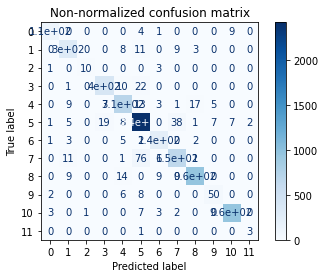

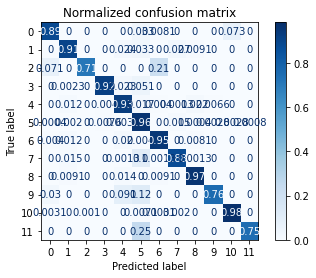

2020-05-04 15:26:19 INFO     Done cross-validating the learned SVM classifier.


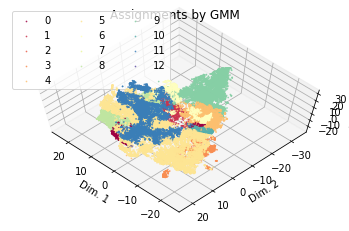

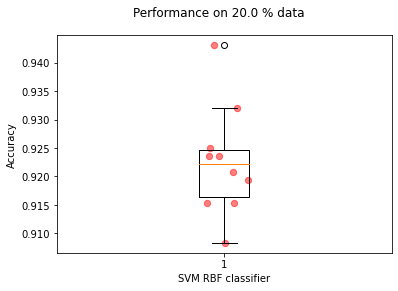

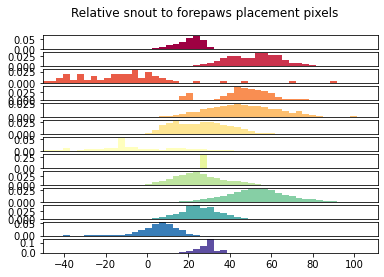

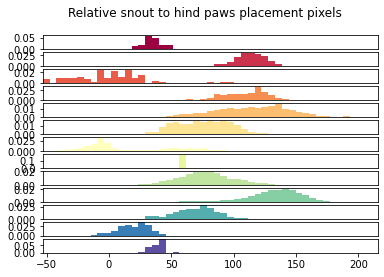

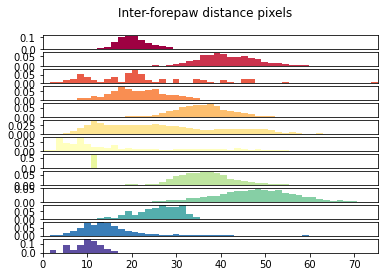

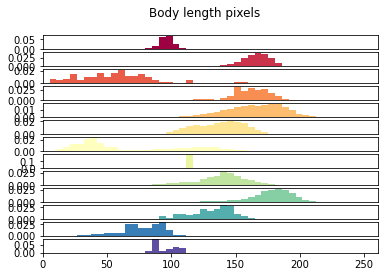

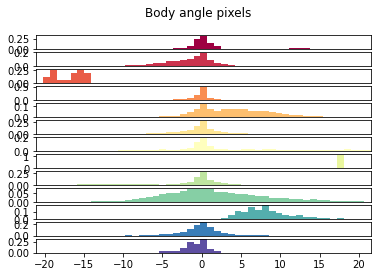

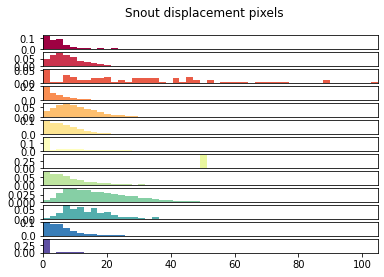

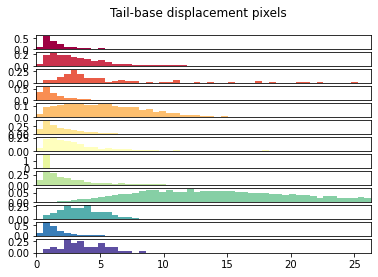

2020-05-04 15:26:53 INFO     Saved.


In [17]:
f_10fps, trained_tsne, scaler, gmm_assignments, classifier, scores = bsoid_build(TRAIN_FOLDERS)

# Predict new datasets with high consistency using your own model!

2020-05-04 15:57:59 INFO     Importing CSV file 1 from folder 1
2020-05-04 15:58:00 INFO     Extracting likelihood value...
2020-05-04 15:58:01 INFO     Computing data threshold to forward fill any sub-threshold (x,y)...


100%|██████████| 6/6 [00:07<00:00,  1.33s/it]

2020-05-04 15:58:09 INFO     Done preprocessing (x,y) from file 1, folder 1.
2020-05-04 15:58:09 INFO     Importing CSV file 2 from folder 1


2020-05-04 15:58:10 INFO     Extracting likelihood value...
2020-05-04 15:58:10 INFO     Computing data threshold to forward fill any sub-threshold (x,y)...


100%|██████████| 6/6 [00:08<00:00,  1.37s/it]

2020-05-04 15:58:18 INFO     Done preprocessing (x,y) from file 2, folder 1.
2020-05-04 15:58:18 INFO     Processed 2 CSV files from folder: 041919
2020-05-04 15:58:18 INFO     Processed a total of 2 CSV files, and compiled into a (2, 107999, 12) data list.
2020-05-04 15:58:18 INFO     Extracting features from CSV file 1...


2020-05-04 15:58:31 INFO     Extracting features from CSV file 2...
2020-05-04 15:58:44 INFO     Done extracting features from a total of 2 training CSV files.
2020-05-04 15:58:47 INFO     Done integrating features into 100ms bins from CSV file 1.
2020-05-04 15:58:49 INFO     Done integrating features into 100ms bins from CSV file 2.
2020-05-04 15:58:49 INFO     Predicting file 1 with 17999 instances using learned classifier: bsoid_c57bl6_n2_120min...
2020-05-04 15:58:55 INFO     Done predicting file 1 with 17999 instances in 7 D space.
2020-05-04 15:58:55 INFO     Predicting file 2 with 17999 instances using learned classifier: bsoid_c57bl6_n2_120min...
2020-05-04 15:59:00 INFO     Done predicting file 2 with 17999 instances in 7 D space.
2020-05-04 15:59:00 INFO     Done predicting a total of 2 files.
2020-05-04 15:59:00 INFO     Extracting features from CSV file 1...
2020-05-04 15:59:13 INFO     Extracting features from CSV file 2...
2020-05-04 15:59:25 INFO     Extracting features 

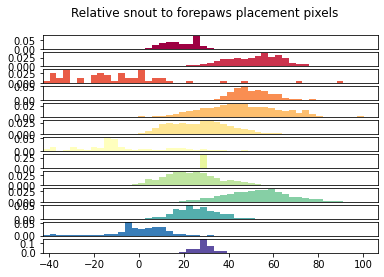

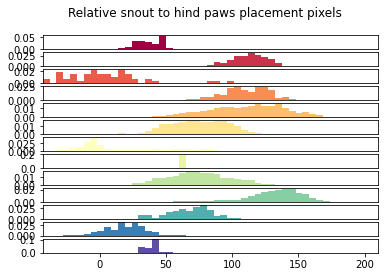

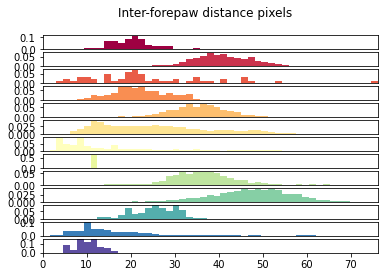

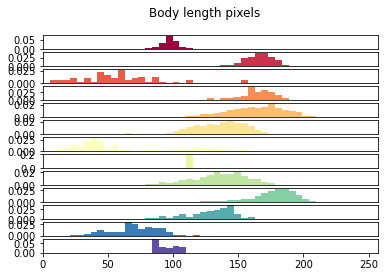

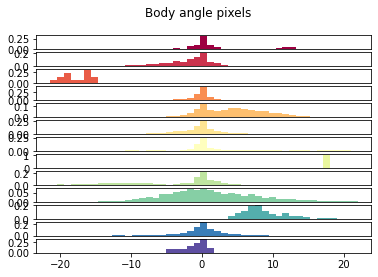

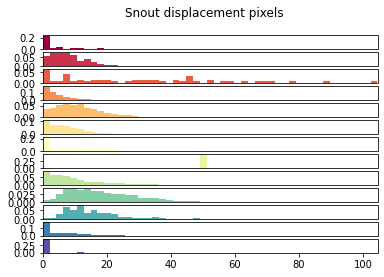

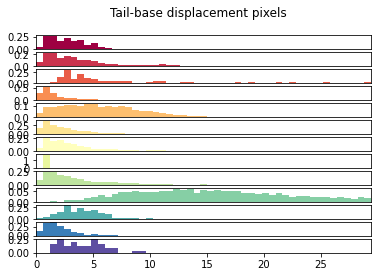

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


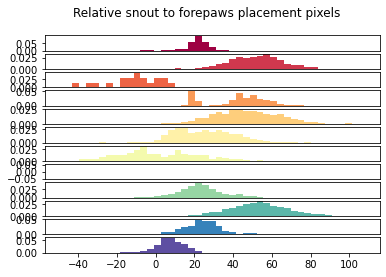

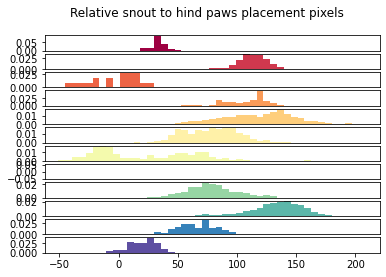

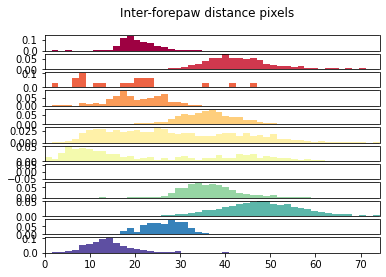

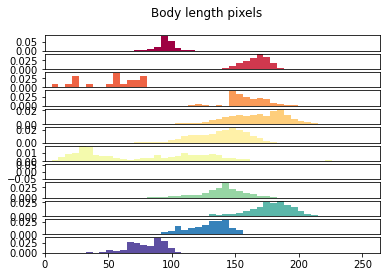

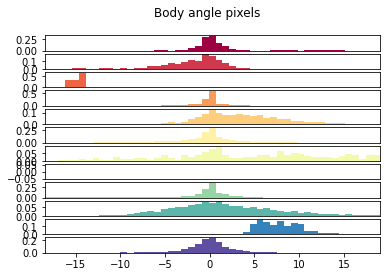

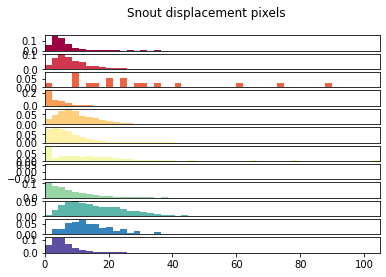

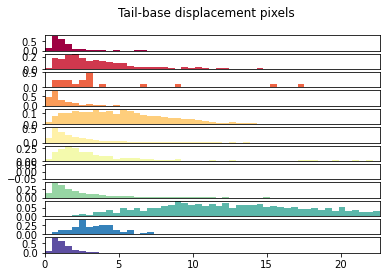

2020-05-04 16:03:58 INFO     Importing CSV file 1 from folder 1
2020-05-04 16:04:00 INFO     Importing CSV file 2 from folder 1
2020-05-04 16:04:01 INFO     NumExpr defaulting to 2 threads.


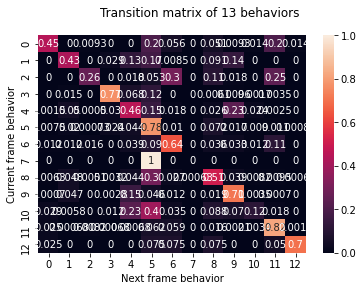

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


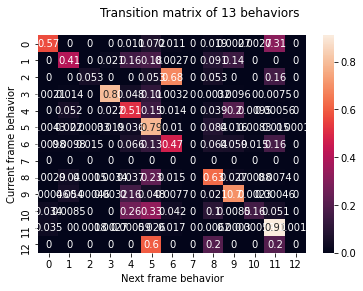

2020-05-04 16:04:07 INFO     All saved.


In [22]:
data_new, feats_new, labels_fslow, labels_fshigh = bsoid_run(PREDICT_FOLDERS)